In [2]:
%matplotlib inline
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [3]:
class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        if activation == "sigmoid":
            self.output = self.sigmoid(self.calculate_net_input()) 
        elif activation == "relu":
            self.output = self.relu(self.calculate_net_input()) 
        return self.output

    def calculate_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    def sigmoid(self, net_input):
        return 1 / (1 + math.exp(-net_input))

    def relu(self, net_input):
        return max(0, net_input)

    def least_squares_error(self, target):
        return 0.5 * (target - self.output) ** 2
    
    def l1_error(self, target):
        return (target - self.output)

    # What's next?
    # Need to determine how much the neuron's total input has to change to move closer to the expected output
    # What is this value?
    # ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ

    def derivative_error_wrt_net_input(self, target):
        return self.derivative_error_wrt_output(target) * self.derivative_output_wrt_net_input()

    # Least Squares Error: 1/2 * (tⱼ - yⱼ)^2
    # The partial derivate of the error with respect to actual output then is calculated by:
    # ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def derivative_error_wrt_output(self, target):
        #print("derivative_error_wrt_output = ", -1 * (target - self.output))
        return -1 * (target - self.output)

    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def derivative_output_wrt_net_input(self):
        if activation == "sigmoid":
            return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def derivative_net_input_wrt_weight(self, index):
        #print("derivative_net_input_wrt_weight", self.inputs[index])
        return self.inputs[index]

In [4]:
class Layer:
    """
    Creates a Layer in the network consisting of neurons/units. Each layer has one bias.

    N, Integer     : number of neurons/units in the layer
    bias, Float    : bias of the layer
    neurons, Neuron: list of objects of class Neuron
    """
    def __init__(self, N, bias):
        if bias:
            self.bias = bias
        else:
            self.bias = random.random()

        # initialize empty array of neurons
        self.neurons = []

        # append new Neurons to array
        for i in range(N):
            self.neurons.append(Neuron(self.bias))

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs
    
    def inspect(self):
        print('TOTAL NEURONS:', len(self.neurons))
        for n in range(len(self.neurons)):
            print('Neuron  :', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)
            
            
    def inspect_datapoint(self, inputs):
        print("Neurons: %d" % len(self.neurons))
        outputs = []
        for n in range(len(self.neurons)):
            print("Neuron : %d" % n)
            op = self.neurons[n].calculate_output(inputs)
            outputs.append(op)
            print("Output : %f" % op)
        return outputs


In [5]:
class NeuralNetwork:
    learning_rate = 0.5 # very important! Too low (0.1) will not adjust weights correctly.

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_bias = None, output_layer_weights = None):
        self.num_inputs = num_inputs
        self.hidden_layer = Layer(num_hidden, hidden_layer_bias)
        self.output_layer = Layer(num_outputs, output_layer_bias)
        # Let's initialize those weights we got there!
        self.initialize_weights_hidden_layer(hidden_layer_weights)
        self.initialize_weights_output_layer(output_layer_weights)

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')
        
    def inspect_datapoint(self, inputs, show_hidden_layer=False):
        if show_hidden_layer == True:
            print('------')
            print('* Inputs: {}'.format(self.num_inputs))
            print('------')
            print('Hidden Layer')
        hidden_layer_outputs = self.hidden_layer.inspect_datapoint(inputs)
        print('================== Output Layer ==================')
        output_layer_outputs = self.output_layer.inspect_datapoint(hidden_layer_outputs)
        
        
    def initialize_weights_hidden_layer(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                else:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                weight_num += 1


    def initialize_weights_output_layer(self, output_layer_weights):
        weight_num = 0
        for h in range(len(self.output_layer.neurons)):
            for i in range(len(self.hidden_layer.neurons)):
                if output_layer_weights:
                    self.output_layer.neurons[h].weights.append(output_layer_weights[weight_num])
                else:
                    self.output_layer.neurons[h].weights.append(random.random())
                weight_num += 1

    # Helper method in train() (Below)
    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Using Stochastic Gradient Descent
    # Parameter "inputs" is the input to the network.
    # Parameter "target" is the groundtruth label for the given output.
    def train(self, inputs, target, inspect_gradient = False):
        self.feed_forward(inputs)

        # Step 1: Calculate output neurons derivative 
        # Calculate ∂E/∂z
        derivative_error_wrt_output_layer_net_input = [0] * len(self.output_layer.neurons)
        for i in range(len(self.output_layer.neurons)):
            #  Calculate ∂E/∂zⱼ
            derivative_error_wrt_output_layer_net_input[i] = self.output_layer.neurons[i].derivative_error_wrt_net_input(target[i])

        # Step 2: Calculate hidden neurons derivative
        # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
        derivative_error_wrt_hidden_layer_net_input = [0] * len(self.hidden_layer.neurons)
        for i in range(len(self.hidden_layer.neurons)):
            temp = 0
            for j in range(len(self.output_layer.neurons)):
                temp += derivative_error_wrt_output_layer_net_input[j] * self.output_layer.neurons[j].weights[i]

            derivative_error_wrt_hidden_layer_net_input[i] = temp * self.hidden_layer.neurons[i].derivative_output_wrt_net_input()

        # Step 3: Update output neurons weights
        for o in range(len(self.output_layer.neurons)):
            for weight_num in range(len(self.output_layer.neurons[o].weights)):
                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                derivative_error_wrt_weight = derivative_error_wrt_output_layer_net_input[o] * self.output_layer.neurons[o].derivative_net_input_wrt_weight(weight_num)
                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[weight_num] -= self.learning_rate * derivative_error_wrt_weight
                if inspect_gradient:
                    print(" Output Neuron ",o, "weight ",weight_num, "gradient: ",derivative_error_wrt_weight, "del error/net_input", derivative_error_wrt_output_layer_net_input[o])
            self.output_layer.neurons[o].bias -= self.learning_rate * derivative_error_wrt_output_layer_net_input[o]
                    

        # Step 4: Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for weight_num in range(len(self.hidden_layer.neurons[h].weights)):
                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                derivative_error_wrt_weight = derivative_error_wrt_hidden_layer_net_input[h] * self.hidden_layer.neurons[h].derivative_net_input_wrt_weight(weight_num)
                self.hidden_layer.neurons[h].weights[weight_num] -= self.learning_rate * derivative_error_wrt_weight
                if inspect_gradient:
                    print(" Hidden Neuron ",h, "weight ",weight_num, "gradient: ",derivative_error_wrt_weight, "del error/net_input", derivative_error_wrt_hidden_layer_net_input[h])
            self.hidden_layer.neurons[h].bias -= self.learning_rate * derivative_error_wrt_hidden_layer_net_input[h]
                    
                    
    def calculate_total_error(self, training_data):
        total_error = 0
        for i in range(len(training_data)):
            training_x, training_output = training_data[i]
            self.feed_forward(training_x)

            for k in range(len(training_output)):
                #total_error += self.output_layer.neurons[k].l1_error(training_output[k])
                total_error += self.output_layer.neurons[k].least_squares_error(training_output[k])
        return total_error
    
    def test_cases(self, training_data):
        for i in range(len(training_data)):
            training_x, training_output = training_data[i]
            print("------ ")
            self.feed_forward(training_x) # trains
            self.inspect_datapoint(training_data[i][0])
            print("Target : [%d]" % training_output[0])
            print("Input  : [%d, %d]" % (training_x[0], training_x[1]))
            print("==================================================\n\n")  
    


In [6]:
def plot_learning_curves(t,error, color='b'):
    plt.plot(t, error, color = color)

In [7]:
# --------- End of Given Code, Starting of Own Code ---------
#
# Author      : Louise Y. Lai
# Email       : ll2663@nyu.edu
# N-Number    : N12709809
# Description : The program trains a Neural Network with two hidden layers to 'learn' the XOR operation
#

In [9]:
# RUN ME!
# Build the training set

N = 20 # number of training sets
V = 10 # range of values 
trainingData = []

for i in range(N):
    first = randint(0, V)
    second = randint(0, V)
    answer = first * second
    
    # take the log of everything, so the answer is an addition problem
    trainingData.append([[first, second], [answer]])

# Choose an activation function 
activation = "sigmoid"

# Choose number of inputs, hidden layers and outputs
myNN = NeuralNetwork(num_inputs=2,num_hidden=10,num_outputs=1)

# Choose number of iterations
num_iterations = 10

# Train the NN
for i in range(num_iterations):
    for k in range(len(trainingData)):
        NeuralNetwork.train(myNN, inputs=trainingData[k][0],target=trainingData[k][1]) 

# Feed the NN input to produce output
NeuralNetwork.test_cases(myNN, trainingData)


------ 
Neurons: 10
Neuron : 0
Output : 0.999459
Neuron : 1
Output : 0.997933
Neuron : 2
Output : 0.999979
Neuron : 3
Output : 0.994246
Neuron : 4
Output : 0.996179
Neuron : 5
Output : 0.999952
Neuron : 6
Output : 0.999902
Neuron : 7
Output : 0.993398
Neuron : 8
Output : 0.999865
Neuron : 9
Output : 0.946698
================== Output Layer ==================
Neurons: 1
Neuron : 0
Output : 0.999983
Target : [56]
Input  : [7, 8]


------ 
Neurons: 10
Neuron : 0
Output : 0.999120
Neuron : 1
Output : 0.992954
Neuron : 2
Output : 0.999909
Neuron : 3
Output : 0.991080
Neuron : 4
Output : 0.992683
Neuron : 5
Output : 0.999853
Neuron : 6
Output : 0.999660
Neuron : 7
Output : 0.982083
Neuron : 8
Output : 0.999795
Neuron : 9
Output : 0.931073
================== Output Layer ==================
Neurons: 1
Neuron : 0
Output : 0.999982
Target : [40]
Input  : [5, 8]


------ 
Neurons: 10
Neuron : 0
Output : 0.999037
Neuron : 1
Output : 0.999550
Neuron : 2
Output : 0.999992
Neuron : 3
Output : 0.99368

In [8]:
# We can see that the output is very close to zero (0.01) and very close to one (0.98) when at the right times.
# Hurray! We have successfully trained the Neural Network to learn the XOR algorithm using fundamental concepts 
# such as back propogation, learning rates and activation functions.
#
# Below, we move on to plotting error rates.

Error over 1000 iterations:


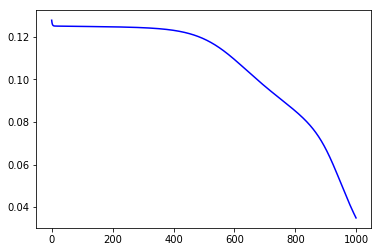

In [9]:
# Loading Data and training (steps are same as above)
trainingData = [[[1,1], [0]],
                [[1,0], [1]],
                [[0,1], [1]],
                [[0,0], [0]]]
activation = "sigmoid"
myNN = NeuralNetwork(num_inputs=2,num_hidden=2,num_outputs=1)
num_iterations = 1000

average_errors = [] # an array of 1000 errors, corresponding to number of iterations
for i in range(num_iterations):
    for k in range(len(trainingData)):
        NeuralNetwork.train(myNN, inputs=trainingData[k][0],target=trainingData[k][1])
    average_error = NeuralNetwork.calculate_total_error(myNN, trainingData) / len(trainingData) 
    average_errors.append(average_error)

plot_learning_curves(np.arange(num_iterations), average_errors)
print ("Error over %d iterations:" % num_iterations)


In [10]:
# NOTE: 
# if a sharp 'L' shaped graph appears, please re-run the code. It should look sharp AND THEN decreasing.
#
# OBSERVATIONS:
# We see that as the number of iterations increase (x-axis), the average error decreases (y-axis). The sharpest 
# error reduction happens in the earliest iterations. Then, it decreases at a gradual but not at a uniform pace. 
# As the code is re-run, the shape of the graph changes. Sometimes, the error is dramatically reduced within the 
# first few iterations, creating a long, almost vertical line in the beginning. Other times, the initial error 
# reduction is not that great, and error reduction is more gradual throughout the iterations. These observations 
# can be explained by the random assignment of weights at the beginning. Sometimes, the weights can be randomly 
# guessed more 'correctly' than others, resulting in a more accurate output and hence produce lower error rates.
# 
# SIDE NOTE:
# The author learnt a lot about how learning rates can have a huge effect on the NN's accuracy. When the learning
# rate was set low, such as 0.1, the NN was very innacurate. This is becuase low learning rates do not 'punish'
# errors harshly enough during back-propogation. When the learning rate was set higher, such as 0.5, the NN
# works well and is able to achieve near-perfect results. The downside to this is the possibility of overfitting, 
# but since XOR is limited to a relatively simple exercise with just four possible test cases, this is not 
# a cause of concern.